In [1]:
import torch
import re
import pandas as pd
import numpy as np
import seaborn as sns
from torch.nn import functional as F
from normalize_text import normalize
from transformers import AutoModel, AutoTokenizer

In [2]:
from utils import *

# 1. Load raw data

In [42]:
tokenizer = AutoTokenizer.from_pretrained('m3rg-iitd/matscibert')
model = AutoModel.from_pretrained('m3rg-iitd/matscibert')

Some weights of the model checkpoint at m3rg-iitd/matscibert were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at m3rg-iitd/matscibert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
Y

In [43]:
max_length = 128
base_path = './abs_data/'

In [44]:
nas_csv_file = "./abs_data/TITLE-ABS-KEY ( room-temperature AND sodium-sulfur AND batteries ) AND ( DOCTYPE ( ar ) )_1.csv"
lis_csv_file = "./abs_data/TITLE-ABS-KEY (  lithium-sulfur AND electrocatalysts) AND ( DOCTYPE ( ar ) )_1.csv"
sa_csv_file = "./abs_data/TITLE-ABS-KEY ( single-atom AND electrocatalysts ) AND ( DOCTYPE ( ar ) )_1.csv"
lissa_csv_file = r"./abs_data/Li-S SA_1.csv"
irrelevant1_csv_file = r'./abs_data/Low_relevant_1.csv'
irrelevant2_csv_file = r'./abs_data/Low_relevant_2.csv'

In [45]:
nas_df, nas_list = load_csv_abstracts(nas_csv_file)
lis_df, lis_list = load_csv_abstracts(lis_csv_file)
lissa_df, lissa_list = load_csv_abstracts(lissa_csv_file)
sa_df, sa_list = load_csv_abstracts(sa_csv_file)

ir1_df, ir1_list = load_csv_abstracts(irrelevant1_csv_file)
ir2_df, ir2_list = load_csv_abstracts(irrelevant2_csv_file)

Check duplicate abstracts

In [46]:
sa_df.shape, lis_df.shape, lissa_df.shape

((1218, 4), (312, 4), (81, 4))

In [47]:
check_duplicate_df = pd.concat([sa_df, lis_df, lissa_df])
check_duplicate_df.columns, check_duplicate_df.shape

(Index(['title', 'abs', 'pub', 'doi'], dtype='object'), (1611, 4))

In [48]:
check_series = check_duplicate_df.duplicated(subset='doi', keep='last')
sa_check_series = check_series[:sa_df.shape[0]]
lis_check_series = check_series[sa_df.shape[0]:sa_df.shape[0] + lis_df.shape[0]]
lissa_check_series = check_series[-lissa_df.shape[0]:]
del check_duplicate_df

In [49]:
print(sa_check_series.value_counts())
sa_df[sa_check_series==False].shape

False    1198
True       20
dtype: int64


(1198, 4)

In [50]:
def remove_duplicate(check_series, df, abs_list):
    print(check_series.value_counts())
    new_df = df[check_series==False]
    new_list = [] 
    for check, abs in zip(check_series, abs_list):
        if check == False:
            new_list.append(abs)
    return new_df, new_list

In [51]:
sa_df, sa_list = remove_duplicate(sa_check_series, sa_df, sa_list)
lis_df, lis_list = remove_duplicate(lis_check_series, lis_df, lis_list)
lissa_df, lissa_list = remove_duplicate(lissa_check_series, lissa_df, lissa_list)

False    1198
True       20
dtype: int64
False    297
True      15
dtype: int64
False    81
dtype: int64


In [52]:
print(">>> statistical info")
print("NaS: {nas}  |  LiS:  {lis}  |  Sa:  {sa}  |  LiSSA: {lissa}".
        format(nas=len(nas_list), lis=len(lis_list), sa=len(sa_list), lissa=len(lissa_list)))
print("Irrelevant 1: {ir1}  |  Irrelevant 2: {ir2}".format(ir1=len(ir1_list), ir2=len(ir2_list)))

>>> statistical info
NaS: 202  |  LiS:  297  |  Sa:  1198  |  LiSSA: 81
Irrelevant 1: 623  |  Irrelevant 2: 1234


# 2. Retrieve MatSciBert Embeddings

In [53]:
# if pre calculated
emb_nas_list = torch.load('./embs/nas_list.pt')
emb_sa_list = torch.load('./embs/sa_list.pt')
emb_lis_list = torch.load('./embs/lis_list.pt')
emb_lissa_list = torch.load('./embs/lissa_list.pt')
emb_ir1_list = torch.load('./embs/ir1_list.pt')
emb_ir2_list = torch.load('./embs/ir2_list.pt')

In [54]:
# remove duplicate abstracts' embeddings
def remove_duplicate_embs(check_series, emb_list):
    new_list = [] 
    for check, emb in zip(check_series, emb_list):
        if check == False:
            new_list.append(emb)
    return new_list
emb_sa_list = remove_duplicate_embs(sa_check_series, emb_sa_list)
emb_lis_list = remove_duplicate_embs(lis_check_series, emb_lis_list)

In [55]:
# # calculate other emebeddings
# tokenized_lissa_list = [tokenize_sentences(lissa, tokenizer, max_length) for lissa in lissa_list]
# tokenized_ir1_list = [tokenize_sentences(ir, tokenizer, max_length) for ir in ir1_list]
# tokenized_ir2_list = [tokenize_sentences(ir, tokenizer, max_length) for ir in ir2_list]

In [56]:
# emb_lissa_list = [get_sum_hidden_emb(tokenized_lissa, model) for tokenized_lissa in tokenized_lissa_list]
# del tokenized_lissa_list

In [57]:
# emb_ir1_list = [get_sum_hidden_emb(tokenized_ir, model) for tokenized_ir in tokenized_ir1_list]
# del tokenized_ir1_list

In [58]:
# emb_ir2_list = [get_sum_hidden_emb(tokenized_ir, model) for tokenized_ir in tokenized_ir2_list]
# del tokenized_ir2_list

In [59]:
nas_sa_list = []
for i in range(1, 6):
    nas_sa_list.append(load_paper_to_sentences(base_path + 'nasa_{i}.txt'.format(i=i)))
tokenized_nas_sa_list = [tokenize_sentences(nasa, tokenizer, max_length) for nasa in nas_sa_list]
emb_nas_sa_list = [get_sum_hidden_emb(tokenized_nasa, model) for tokenized_nasa in tokenized_nas_sa_list]

In [60]:
# # save emb
# torch.save(emb_lissa_list, './embs/lissa_list.pt')
# torch.save(emb_ir1_list, './embs/ir1_list.pt')
# torch.save(emb_ir2_list, './embs/ir2_list.pt')

In [61]:
# release memory
del tokenizer, model

# 3. Create Labeled Dataset

In [62]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class AbstractDataset(Dataset):
    def __init__(self, emb_nas_list, emb_lis_list, emb_sa_list, emb_lissa_list,
                       emb_ir1_list, emb_ir2_list) -> None:
        # create labels
        label_nas = torch.full([len(emb_nas_list)], 0)
        label_lis = torch.full([len(emb_lis_list)], 1)
        label_sa = torch.full([len(emb_sa_list)], 2)
        label_lissa = torch.full([len(emb_lissa_list)], 3)
        label_ir1 = torch.full([len(emb_ir1_list)], 4)
        label_ir2 = torch.full([len(emb_ir2_list)], 5)
        self.labels = torch.cat([label_nas, label_lis, label_sa, label_lissa, label_ir1, label_ir2])
        # data
        emb_nas = torch.stack(emb_nas_list)
        emb_lis = torch.stack(emb_lis_list)
        emb_sa = torch.stack(emb_sa_list)
        emb_lissa = torch.stack(emb_lissa_list)
        emb_ir1 = torch.stack(emb_ir1_list)
        emb_ir2 = torch.stack(emb_ir2_list)
        self.data = torch.cat([emb_nas, emb_lis, emb_sa, emb_lissa, emb_ir1, emb_ir2])
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]     

In [63]:
dataset = AbstractDataset(emb_nas_list, emb_lis_list, emb_sa_list, emb_lissa_list, emb_ir1_list, emb_ir2_list)
len(dataset)

3635

In [64]:
# split train, test set
from sklearn.model_selection import train_test_split

def gen_train_test_idxs(offset, cls_idxs, test_rate=0, train_test_num={}):
    if test_rate > 0:
        train_idxs, test_idxs = train_test_split(cls_idxs, test_size=test_rate)
    else:
        train_idxs, test_idxs = train_test_split(cls_idxs, train_size = train_test_num['train'], test_size = train_test_num['test'])
    print("Train size: {tr} | Test size: {te}".format(tr=len(train_idxs), te=len(test_idxs)))
    return [idx + offset for idx in train_idxs], [idx + offset for idx in test_idxs]

In [87]:
# each class has a maximun number of 300
start_offset = 0
cut_points = []
train_idxs, val_idxs = [], []
# nas
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_nas_list))), test_rate=0.1)
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_nas_list)])
start_offset += len(emb_nas_list)
# lis
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_lis_list))), test_rate=0.1)
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_lis_list)])
start_offset += len(emb_lis_list)
# sa
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_sa_list))), train_test_num={'train': 270, 'test':30})
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_sa_list)])
start_offset += len(emb_sa_list)
# lissa
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_lissa_list))), test_rate=0.1)
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_lissa_list)])
start_offset += len(emb_lissa_list)
# ir1
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_ir1_list))), train_test_num={'train': 270, 'test':30})
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_ir1_list)])
start_offset += len(emb_ir1_list)
# ir2
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_ir2_list))), train_test_num={'train': 270, 'test':30})
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_ir2_list)])
start_offset += len(emb_ir2_list)

Train size: 181 | Test size: 21
Train size: 267 | Test size: 30
Train size: 270 | Test size: 30
Train size: 72 | Test size: 9
Train size: 270 | Test size: 30
Train size: 270 | Test size: 30


In [88]:
len(train_idxs), len(val_idxs)

(1330, 150)

# 4. Train LR for Augmented Embeddings

In [67]:
import torch.nn as nn
class LR(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        # self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        return self.linear(self.dropout(x))
    
    def retrieve_emb(self, x):
        return self.linear(x)

In [68]:
import torch.optim as optim

class EarlyStopping:
    def __init__(self, patience=10, name='', base='./mlp_models/'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.name = name
        self.base = base

    def step(self, acc, model):
        score = acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.base + self.name + '_checkpoint.pt')

def evaluate(dataloader, model):
    model.eval()
    total = 0
    total_correct = 0
    for batched_data, labels in dataloader:
        total += len(labels)
        logits = model(batched_data)
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
    acc = 1.0 * total_correct / total
    return acc

def train(model, train_loader, val_loader, epochs, lr=0.01, verbose=True, stopper=None):
    # loss function, optimizer and scheduler
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    # training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch, (batched_data, labels) in enumerate(train_loader):
            logits = model(batched_data)
            loss = loss_fcn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        train_acc = evaluate(train_loader, model)
        valid_acc = evaluate(val_loader, model)
        if verbose:
            print(
                "Epoch {:05d} | Loss {:.4f} | Train Acc. {:.4f} | Validation Acc. {:.4f} ".format(
                    epoch, total_loss / (batch + 1), train_acc, valid_acc
                )
            )
        if stopper is not None:
            if stopper.step(valid_acc, model):
                break

In [89]:
from datetime import datetime
in_dim = emb_sa_list[0].shape[0]
out_dim = 6

name = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
early_stop = EarlyStopping(patience=7, name=name)

# del mlp

model = LR(in_dim, out_dim, dropout=0.8)
model

LR(
  (linear): Linear(in_features=98304, out_features=6, bias=False)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [90]:
from torch.utils.data.sampler import SubsetRandomSampler
train_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler(train_idxs), batch_size=256)
test_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler(val_idxs), batch_size=256)
# train_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler([0,1,2]), batch_size=1)
# test_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler([8,24]), batch_size=1)

In [91]:
epochs = 100
train(model, train_dataloader, test_dataloader, epochs, stopper=early_stop)

Epoch 00000 | Loss 587.9593 | Train Acc. 0.2030 | Validation Acc. 0.2000 
Epoch 00001 | Loss 763.9102 | Train Acc. 0.2609 | Validation Acc. 0.2267 
Epoch 00002 | Loss 296.0874 | Train Acc. 0.5714 | Validation Acc. 0.5133 
Epoch 00003 | Loss 234.7070 | Train Acc. 0.6820 | Validation Acc. 0.6133 
Epoch 00004 | Loss 148.0441 | Train Acc. 0.7218 | Validation Acc. 0.6467 
Epoch 00005 | Loss 55.3305 | Train Acc. 0.7579 | Validation Acc. 0.6667 
Epoch 00006 | Loss 45.6503 | Train Acc. 0.9000 | Validation Acc. 0.7667 
Epoch 00007 | Loss 20.6368 | Train Acc. 0.8293 | Validation Acc. 0.6467 
EarlyStopping counter: 1 out of 7
Epoch 00008 | Loss 16.7429 | Train Acc. 0.9436 | Validation Acc. 0.7667 
Epoch 00009 | Loss 9.9914 | Train Acc. 0.9406 | Validation Acc. 0.7533 
EarlyStopping counter: 1 out of 7
Epoch 00010 | Loss 8.1539 | Train Acc. 0.9789 | Validation Acc. 0.7867 
Epoch 00011 | Loss 5.2221 | Train Acc. 0.9767 | Validation Acc. 0.7933 
Epoch 00012 | Loss 5.6539 | Train Acc. 0.9850 | Valida

In [92]:
evaluate(test_dataloader, model)

0.8133333333333334

## Metrics records

In [93]:
from sklearn import metrics

In [94]:
model.eval()
feats, labels = dataset[val_idxs]
logits = model(feats)
_, preds = torch.max(logits, 1)

In [95]:
np_logits = logits.detach().softmax(dim=1).numpy()

In [96]:
metrics.precision_recall_fscore_support(labels, preds, average='weighted')

(0.8217426108374384, 0.8133333333333334, 0.8066044981080519, None)

In [97]:
# AUROC
metrics.roc_auc_score(labels, np_logits, multi_class='ovo')

0.9340890652557319

In [98]:
aupr_labels = torch.zeros(labels.shape[0], 6)
for i, label in enumerate(labels):
    aupr_labels[i][label] = 1
aupr_labels = aupr_labels.numpy()

In [99]:
# AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(aupr_labels[:, i],
                                                        np_logits[:, i])
    average_precision[i] = average_precision_score(aupr_labels[:, i], np_logits[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(aupr_labels.ravel(),
    np_logits.ravel())
average_precision["micro"] = average_precision_score(aupr_labels, np_logits,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.4f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.7734


# Plot

In [23]:
l_nas = np.array(['nas' for _ in range(len(emb_nas_list))])
l_sa = np.array(['sa' for _ in range(len(emb_sa_list))])
l_lis = np.array(['lis' for _ in range(len(emb_lis_list))])
l_lissa = np.array(['lissa' for _ in range(len(emb_lissa_list))])
l_ir1 = np.array(['ir1' for _ in range(len(emb_ir1_list))])
l_ir2 = np.array(['ir2' for _ in range(len(emb_ir2_list))])
l_nassa = np.array(['nassa' for _ in range(len(emb_nas_sa_list))])

In [24]:
labels = np.concatenate((l_nas, l_sa, l_lis, l_lissa, l_ir1, l_ir2, l_nassa), axis=0)
labels.shape

(3640,)

In [25]:
emb_nas = torch.stack(emb_nas_list)
emb_lis = torch.stack(emb_lis_list)
emb_sa = torch.stack(emb_sa_list)
emb_lissa = torch.stack(emb_lissa_list)
emb_ir1 = torch.stack(emb_ir1_list)
emb_ir2 = torch.stack(emb_ir2_list)
emb_nas_sa = torch.stack(emb_nas_sa_list)
all_embs = torch.cat([emb_nas, emb_lis, emb_sa, emb_lissa, emb_ir1, emb_ir2, emb_nas_sa])
compare_embs = torch.cat([emb_nas, emb_lis, emb_sa, emb_lissa, emb_ir1, emb_ir2])

In [26]:
embs_np = all_embs.detach().numpy()

In [27]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [28]:
# save memory
del emb_nas, emb_lis, emb_sa, emb_lissa, emb_ir1, emb_ir2, emb_nas_sa, all_embs, compare_embs

In [29]:
# save memory
del emb_nas_list, emb_lis_list, emb_sa_list, emb_lissa_list, emb_ir1_list, emb_ir2_list, emb_nas_sa_list
del l_nas, l_sa, l_lis, l_lissa, l_ir1, l_ir2, l_nassa

In [30]:
embs_np.shape

(3640, 98304)

In [31]:
from bhtsne import tsne as c_tsne

In [32]:
help(c_tsne)

Help on function tsne in module bhtsne:

tsne(data, dimensions=2, perplexity=30.0, theta=0.5, rand_seed=-1, seed_positions=array([], dtype=float64))



In [33]:
embs_np.dtype

dtype('float32')

In [34]:
embs_np64 = np.float64(embs_np)
embs_np64.dtype

dtype('float64')

In [35]:
del embs_np

In [36]:
# tsne = TSNE(n_components=2)
# embs_tsne = tsne.fit_transform(embs_np)
embs_tsne = c_tsne(embs_np64)

Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 3640
Input similarities computed in 1209.71 seconds (sparsity = 0.047535)!
Learning embedding...
Iteration 50: error is 104.605163 (50 iterations in 1.82 seconds)
Iteration 100: error is 110.531443 (50 iterations in 1.66 seconds)
Iteration 150: error is 113.041394 (50 iterations in 1.43 seconds)
Iteration 200: error is 116.543560 (50 iterations in 1.28 seconds)
Iteration 250: error is 7.398233 (50 iterations in 1.17 seconds)
Iteration 300: error is 5.810697 (50 iterations in 1.61 seconds)
Iteration 350: error is 5.020905 (50 iterations in 1.58 seconds)
Iteration 400: error is 4.342656 (50 iterations in 1.61 seconds)
Iteration 450: error is 4.257175 (50 iterations in 1.57 seconds)
Iteration 500: error is 3.985777 (50 iterations in 1.58 seconds)
Iteration 550: error is 3.321855 (50 iterations in 0.93 seconds)
Iteration 600: er

In [37]:
embs_tsne.shape

(3640, 2)

In [38]:
df_temp = pd.DataFrame(embs_tsne, columns=['dim1', 'dim2'])
df_label = pd.DataFrame(labels, columns=['class'])
df_tsne = pd.concat([df_temp, df_label], axis=1, ignore_index=False)

In [39]:
print("> saving result..")
df_tsne.to_csv("./save_files/bert_tsne.csv")

> saving result..


In [40]:
df_tsne.head()

,dim1,dim2,class
0,1.302559,0.780823,nas
1,4.192036,2.285130,nas
2,-2.135937,-5.931138,nas
3,0.541569,1.068874,nas
4,0.428529,-1.134548,nas


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

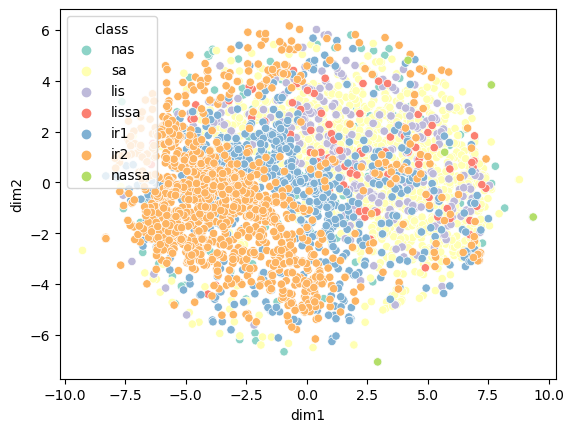

In [41]:
sns.scatterplot(data=df_tsne, hue='class', x='dim1', y='dim2', palette='Set3')